<a href="https://colab.research.google.com/github/akramhilmi/ml-assignment-mindcraft/blob/main/ML_Assignment_MindCraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WIA1006 MACHINE LEARNING ASSIGNMENT

**Group Name**

MindCraft

**Group Members**
1. AKRAM HILMI BIN HASNUDDIN
2. MUHAMMAD FAHIM BIN JAAFAR
3. MUHAMMAD AFIQ BIN MOHD FAUZI
4. MUHAMMAD FARIS DINIE BIN NAZRUL ZAMRI
5. IRFAN FATHI BIN HAMDAN

**Theme**

Hourly Origin-Destination Ridership: Komuter

https://data.gov.my/data-catalogue/ridership_od_komuter

**Problem**

Optimize train schedules by predicting ridership demand

# Data Collection

Load the main dataset from Google Drive.

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df_komuter = pd.read_parquet('/content/drive/MyDrive/ML Assignment - MindCraft/komuter_2024.parquet')
df_komuter

Mounted at /content/drive


,date,time,origin,destination,passengers
0,2024-01-01,00:00,Subang Jaya,Padang Jawa,2
1,2024-01-01,00:00,Kajang,Nilai,3
2,2024-01-01,00:00,KL Sentral,Nilai,10
3,2024-01-01,00:00,KL Sentral,Bukit Badak,6
4,2024-01-01,00:00,KL Sentral,Klang,16
...,...,...,...,...,...
2686238,2024-11-11,19:00,Unknown,Unknown,1
2686239,2024-11-21,16:00,Unknown,Unknown,1
2686240,2024-12-04,09:00,Unknown,Unknown,1
2686241,2024-12-14,15:00,Unknown,Unknown,1


Gather 2024 public holiday data from Google Calendar API.

In [2]:
!pip install google-api-python-client

from google.oauth2 import service_account
from googleapiclient.discovery import build

# Authenticate with the service account
SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']
SERVICE_ACCOUNT_FILE = '/content/drive/MyDrive/ML Assignment - MindCraft/ml-assignment-mindcraft.json'

credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES
)

# Build the Calendar API service
service = build('calendar', 'v3', credentials=credentials)

# Fetch Malaysia's public holidays (Google's predefined calendar)
calendar_id = 'en.malaysia#holiday@group.v.calendar.google.com'
events = service.events().list(
    calendarId=calendar_id,
    timeMin='2024-01-01T00:00:00Z',  # Start year
    timeMax='2024-12-31T23:59:59Z',  # End year
    singleEvents=True,
    orderBy='startTime'
).execute()

# Process events into a DataFrame
holidays = []
for event in events.get('items', []):
    start_date = event['start'].get('date', 'N/A')
    holidays.append({
        'date': start_date,
        'holiday_name': event['summary'],
        'description': event.get('description', '')
    })

df_holiday = pd.DataFrame(holidays)
df_holiday['date'] = pd.to_datetime(df_holiday['date'])  # Convert to datetime
df_holiday

,date,holiday_name,description
0,2024-01-01,New Year's Day (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa..."
1,2024-01-25,Thaipusam (regional holiday),"Public holiday in Johor, Kedah, Negeri Sembila..."
2,2024-02-01,Federal Territory Day (regional holiday),"Public holiday in Kuala Lumpur, Labuan, Putrajaya"
3,2024-02-08,Isra and Mi'raj (regional holiday),"Public holiday in Kedah, Negeri Sembilan, Perl..."
4,2024-02-10,Chinese New Year's Day,Public holiday
5,2024-02-11,Chinese New Year Holiday (regional holiday),"Public holiday in Kelantan, Terengganu, Tereng..."
6,2024-02-11,Second Day of Chinese New Year (regional holiday),"Public holiday in Johor, Kedah, Malacca, Neger..."
7,2024-02-12,Chinese New Year Holiday (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa..."
8,2024-02-14,Valentine's Day,"Observance\nTo hide observances, go to Google ..."
9,2024-03-12,First Day of Ramadan (regional holiday),"Public holiday in Johor, Kedah, Malacca"


# Data Pre-processing

## Data Cleaning

### Komuter dataset

Print all the unique values for each feature.

In [3]:
for column in df_komuter.columns:
  print(f"Unique values for column '{column}':")
  print(df_komuter[column].unique())
  print()

Unique values for column 'date':
<DatetimeArray>
['2024-01-01 00:00:00', '2024-01-02 00:00:00', '2024-01-03 00:00:00',
 '2024-01-04 00:00:00', '2024-01-05 00:00:00', '2024-01-06 00:00:00',
 '2024-01-07 00:00:00', '2024-01-08 00:00:00', '2024-01-09 00:00:00',
 '2024-01-10 00:00:00',
 ...
 '2024-12-22 00:00:00', '2024-12-23 00:00:00', '2024-12-24 00:00:00',
 '2024-12-25 00:00:00', '2024-12-26 00:00:00', '2024-12-27 00:00:00',
 '2024-12-28 00:00:00', '2024-12-29 00:00:00', '2024-12-30 00:00:00',
 '2024-12-31 00:00:00']
Length: 366, dtype: datetime64[us]

Unique values for column 'time':
['00:00' '01:00' '02:00' '03:00' '04:00' '05:00' '06:00' '07:00' '08:00'
 '09:00' '10:00' '11:00' '12:00' '13:00' '14:00' '15:00' '16:00' '17:00'
 '18:00' '19:00' '20:00' '21:00' '22:00' '23:00']

Unique values for column 'origin':
['Subang Jaya' 'Kajang' 'KL Sentral' 'Rawang' 'Sungai Buloh'
 'Tanjong Malim' 'Pulau Sebang (Tampin)' 'Midvalley' 'Taman Wahyu' 'Nilai'
 'Bandar Tasek Selatan' 'Batu Tiga' 'Sent

There are 'Unknown' values in the origin and destination columns of our dataset. Replace them with None to indicate that they are missing values.

In [4]:
df_komuter.replace('Unknown', None, inplace=True)

print(df_komuter.isna().sum())
print()

n_incomplete_rows = df_komuter.isna().any(axis=1).sum()
percentage_incomplete = (n_incomplete_rows / len(df_komuter)) * 100
print(f'Number of incomplete rows: {n_incomplete_rows}')
print(f'Percentage of incomplete rows: {percentage_incomplete:.2f}%')

date               0
time               0
origin         11954
destination     6145
passengers         0
dtype: int64

Number of incomplete rows: 17964
Percentage of incomplete rows: 0.67%


Less than 1% of rows contain missing values. Therefore, we drop all the rows with missing values from the dataframe.

In [5]:
df_komuter.dropna(inplace=True)
df_komuter.reset_index(drop=True, inplace=True)
df_komuter

,date,time,origin,destination,passengers
0,2024-01-01,00:00,Subang Jaya,Padang Jawa,2
1,2024-01-01,00:00,Kajang,Nilai,3
2,2024-01-01,00:00,KL Sentral,Nilai,10
3,2024-01-01,00:00,KL Sentral,Bukit Badak,6
4,2024-01-01,00:00,KL Sentral,Klang,16
...,...,...,...,...,...
2668274,2024-12-31,23:00,Midvalley,Sungai Gadut,1
2668275,2024-12-31,23:00,Subang Jaya,Padang Jawa,8
2668276,2024-12-31,23:00,Abdullah Hukum,Padang Jawa,1
2668277,2024-12-31,23:00,KL Sentral,Padang Jawa,6


### Holiday dataset

Check unique values

In [6]:
for column in df_holiday.columns:
  print(f"Unique values for column '{column}':")
  print(df_holiday[column].unique())
  print()

Unique values for column 'date':
<DatetimeArray>
['2024-01-01 00:00:00', '2024-01-25 00:00:00', '2024-02-01 00:00:00',
 '2024-02-08 00:00:00', '2024-02-10 00:00:00', '2024-02-11 00:00:00',
 '2024-02-12 00:00:00', '2024-02-14 00:00:00', '2024-03-12 00:00:00',
 '2024-03-28 00:00:00', '2024-03-29 00:00:00', '2024-03-31 00:00:00',
 '2024-04-10 00:00:00', '2024-04-11 00:00:00', '2024-05-01 00:00:00',
 '2024-05-22 00:00:00', '2024-05-30 00:00:00', '2024-05-31 00:00:00',
 '2024-06-03 00:00:00', '2024-06-16 00:00:00', '2024-06-17 00:00:00',
 '2024-06-18 00:00:00', '2024-07-07 00:00:00', '2024-07-08 00:00:00',
 '2024-08-31 00:00:00', '2024-09-16 00:00:00', '2024-10-31 00:00:00',
 '2024-12-24 00:00:00', '2024-12-25 00:00:00', '2024-12-31 00:00:00']
Length: 30, dtype: datetime64[ns]

Unique values for column 'holiday_name':
["New Year's Day (regional holiday)" 'Thaipusam (regional holiday)'
 'Federal Territory Day (regional holiday)'
 "Isra and Mi'raj (regional holiday)" "Chinese New Year's Day"


Remove all the observances from the dataset. Include only holidays where the Komuter serves. (Kuala Lumpur, Putrajaya, Selangor and Negeri Sembilan)

In [7]:
# Remove Observances
df_holiday = df_holiday[~df_holiday['description'].str.contains('Observance')]
# Only include holidays for Kuala Lumpur, Putrajaya, Selangor and Negeri Sembilan
df_holiday = df_holiday[(df_holiday['description'] == 'Public holiday') |
                        (df_holiday['description'].str.contains('Kuala Lumpur|Putrajaya|Selangor|Negeri Sembilan'))]

df_holiday.reset_index(drop=True, inplace=True)
df_holiday

,date,holiday_name,description
0,2024-01-01,New Year's Day (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa..."
1,2024-01-25,Thaipusam (regional holiday),"Public holiday in Johor, Kedah, Negeri Sembila..."
2,2024-02-01,Federal Territory Day (regional holiday),"Public holiday in Kuala Lumpur, Labuan, Putrajaya"
3,2024-02-08,Isra and Mi'raj (regional holiday),"Public holiday in Kedah, Negeri Sembilan, Perl..."
4,2024-02-10,Chinese New Year's Day,Public holiday
5,2024-02-11,Second Day of Chinese New Year (regional holiday),"Public holiday in Johor, Kedah, Malacca, Neger..."
6,2024-02-12,Chinese New Year Holiday (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa..."
7,2024-03-28,Nuzul Al-Quran (regional holiday),"Public holiday in Kelantan, Pahang, Penang, Pe..."
8,2024-04-10,Hari Raya Puasa,Public holiday
9,2024-04-11,Hari Raya Puasa Day 2,Public holiday


## Data Transformation

### Komuter dataset

Convert the dataframe into a single station only that represents the origin.

In [8]:
df_komuter = (
    df_komuter
    .groupby(['date', 'time', 'origin'], as_index=False)
    ['passengers']
    .sum()
    .rename(columns={'origin': 'station'})
)
df_komuter

,date,time,station,passengers
0,2024-01-01,00:00,Bandar Tasek Selatan,5
1,2024-01-01,00:00,Bangi,1
2,2024-01-01,00:00,Batu Tiga,1
3,2024-01-01,00:00,KL Sentral,56
4,2024-01-01,00:00,Kajang,9
...,...,...,...,...
366937,2024-12-31,23:00,Subang Jaya,14
366938,2024-12-31,23:00,Sungai Buloh,19
366939,2024-12-31,23:00,Taman Wahyu,1
366940,2024-12-31,23:00,Tanjong Malim,3


Fill missing combinations with zero passengers.

In [9]:
full_index = pd.MultiIndex.from_product(
    [df_komuter['date'].unique(), df_komuter['time'].unique(), df_komuter['station'].unique()],
    names=['date', 'time', 'station']
)

df_komuter = df_komuter.set_index(['date', 'time', 'station']).reindex(full_index, fill_value=0).reset_index()
df_komuter

,date,time,station,passengers
0,2024-01-01,00:00,Bandar Tasek Selatan,5
1,2024-01-01,00:00,Bangi,1
2,2024-01-01,00:00,Batu Tiga,1
3,2024-01-01,00:00,KL Sentral,56
4,2024-01-01,00:00,Kajang,9
...,...,...,...,...
500683,2024-12-31,23:00,Shah Alam,12
500684,2024-12-31,23:00,Telok Pulai,0
500685,2024-12-31,23:00,Tiroi,0
500686,2024-12-31,23:00,Angkasapuri,0


### Holiday dataset

Add features that represent where the holidays are celebrated.

In [10]:
holiday_features = ['is_holiday_kl_putra', 'is_holiday_selangor', 'is_holiday_negeri_sembilan']
df_holiday[holiday_features] = 0
df_holiday.loc[df_holiday['description'] == 'Public holiday', holiday_features] = 1

df_holiday.loc[df_holiday['description'].str.contains('Kuala Lumpur'), 'is_holiday_kl_putra'] = 1
df_holiday.loc[df_holiday['description'].str.contains('Selangor'), 'is_holiday_selangor'] = 1
df_holiday.loc[df_holiday['description'].str.contains('Negeri Sembilan'), 'is_holiday_negeri_sembilan'] = 1

df_holiday

,date,holiday_name,description,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan
0,2024-01-01,New Year's Day (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa...",1,1,1
1,2024-01-25,Thaipusam (regional holiday),"Public holiday in Johor, Kedah, Negeri Sembila...",1,1,1
2,2024-02-01,Federal Territory Day (regional holiday),"Public holiday in Kuala Lumpur, Labuan, Putrajaya",1,0,0
3,2024-02-08,Isra and Mi'raj (regional holiday),"Public holiday in Kedah, Negeri Sembilan, Perl...",0,0,1
4,2024-02-10,Chinese New Year's Day,Public holiday,1,1,1
5,2024-02-11,Second Day of Chinese New Year (regional holiday),"Public holiday in Johor, Kedah, Malacca, Neger...",1,1,1
6,2024-02-12,Chinese New Year Holiday (regional holiday),"Public holiday in Malacca, Negeri Sembilan, Pa...",1,1,1
7,2024-03-28,Nuzul Al-Quran (regional holiday),"Public holiday in Kelantan, Pahang, Penang, Pe...",1,1,0
8,2024-04-10,Hari Raya Puasa,Public holiday,1,1,1
9,2024-04-11,Hari Raya Puasa Day 2,Public holiday,1,1,1


## Data Integration

Combine the Komuter dataset with the holiday dataset.

In [11]:
df = pd.merge(df_komuter, df_holiday[['date'] + holiday_features], on='date', how='left')
df[holiday_features] = df[holiday_features].fillna(0).astype(int)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan
0,2024-01-01,00:00,Bandar Tasek Selatan,5,1,1,1
1,2024-01-01,00:00,Bangi,1,1,1,1
2,2024-01-01,00:00,Batu Tiga,1,1,1,1
3,2024-01-01,00:00,KL Sentral,56,1,1,1
4,2024-01-01,00:00,Kajang,9,1,1,1
...,...,...,...,...,...,...,...
502051,2024-12-31,23:00,Shah Alam,12,0,0,0
502052,2024-12-31,23:00,Telok Pulai,0,0,0,0
502053,2024-12-31,23:00,Tiroi,0,0,0,0
502054,2024-12-31,23:00,Angkasapuri,0,0,0,0


# Feature Engineering

## Feature Extraction

Convert the time feature from a string to an integer value

In [12]:
df['time'] = df['time'].str.replace(':00', '').astype(int)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan
0,2024-01-01,0,Bandar Tasek Selatan,5,1,1,1
1,2024-01-01,0,Bangi,1,1,1,1
2,2024-01-01,0,Batu Tiga,1,1,1,1
3,2024-01-01,0,KL Sentral,56,1,1,1
4,2024-01-01,0,Kajang,9,1,1,1
...,...,...,...,...,...,...,...
502051,2024-12-31,23,Shah Alam,12,0,0,0
502052,2024-12-31,23,Telok Pulai,0,0,0,0
502053,2024-12-31,23,Tiroi,0,0,0,0
502054,2024-12-31,23,Angkasapuri,0,0,0,0


Add day of week and month columns.

In [13]:
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month - 1
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month
0,2024-01-01,0,Bandar Tasek Selatan,5,1,1,1,0,0
1,2024-01-01,0,Bangi,1,1,1,1,0,0
2,2024-01-01,0,Batu Tiga,1,1,1,1,0,0
3,2024-01-01,0,KL Sentral,56,1,1,1,0,0
4,2024-01-01,0,Kajang,9,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,Shah Alam,12,0,0,0,1,11
502052,2024-12-31,23,Telok Pulai,0,0,0,0,1,11
502053,2024-12-31,23,Tiroi,0,0,0,0,1,11
502054,2024-12-31,23,Angkasapuri,0,0,0,0,1,11


Add weekend and rush hour features using one-hot encoding.

In [14]:
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['time'].between(7,9).astype(int) | df['time'].between(17,19).astype(int)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,is_rush_hour
0,2024-01-01,0,Bandar Tasek Selatan,5,1,1,1,0,0,0,0
1,2024-01-01,0,Bangi,1,1,1,1,0,0,0,0
2,2024-01-01,0,Batu Tiga,1,1,1,1,0,0,0,0
3,2024-01-01,0,KL Sentral,56,1,1,1,0,0,0,0
4,2024-01-01,0,Kajang,9,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,Shah Alam,12,0,0,0,1,11,0,0
502052,2024-12-31,23,Telok Pulai,0,0,0,0,1,11,0,0
502053,2024-12-31,23,Tiroi,0,0,0,0,1,11,0,0
502054,2024-12-31,23,Angkasapuri,0,0,0,0,1,11,0,0


Apply cyclical encoding to all time based features.

In [15]:
import numpy as np

df['time_sin'] = np.sin(2 * np.pi * df['time'] / 24)
df['time_cos'] = np.cos(2 * np.pi * df['time'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,is_rush_hour,time_sin,time_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2024-01-01,0,Bandar Tasek Selatan,5,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
1,2024-01-01,0,Bangi,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
2,2024-01-01,0,Batu Tiga,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
3,2024-01-01,0,KL Sentral,56,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
4,2024-01-01,0,Kajang,9,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,Shah Alam,12,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502052,2024-12-31,23,Telok Pulai,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502053,2024-12-31,23,Tiroi,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502054,2024-12-31,23,Angkasapuri,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025


Apply target encoding to the station column.

In [16]:
df['station'] = df.groupby('station')['passengers'].transform('mean')
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,is_rush_hour,time_sin,time_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2024-01-01,0,59.268165,5,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
1,2024-01-01,0,30.378860,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
2,2024-01-01,0,14.769755,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
3,2024-01-01,0,270.490577,56,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
4,2024-01-01,0,56.085604,9,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,33.338556,12,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502052,2024-12-31,23,12.754768,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502053,2024-12-31,23,7.622843,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025
502054,2024-12-31,23,1.345141,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025


Add lagging features.

In [17]:
df['lag_1h'] = df.groupby('station')['passengers'].shift(1)
df['lag_1d'] = df.groupby(['station','time'])['passengers'].shift(1)
df['lag_7d'] = df.groupby(['station','time'])['passengers'].shift(7)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,is_rush_hour,time_sin,time_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d
0,2024-01-01,0,59.268165,5,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN
1,2024-01-01,0,30.378860,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN
2,2024-01-01,0,14.769755,1,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN
3,2024-01-01,0,270.490577,56,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN
4,2024-01-01,0,56.085604,9,1,1,1,0,0,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,33.338556,12,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,31.0,0.0,2.0
502052,2024-12-31,23,12.754768,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,5.0,0.0,0.0
502053,2024-12-31,23,7.622843,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,1.0,2.0,0.0
502054,2024-12-31,23,1.345141,0,0,0,0,1,11,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,4.0,0.0,0.0


Add rolling features.

In [18]:
df['dow_avg'] = df.groupby(['station','day_of_week'])['passengers'].transform(
    lambda x: x.rolling(30, min_periods=5).mean().shift()
)
df['hourly_avg'] = df.groupby(['station','time'])['passengers'].transform(
    lambda x: x.rolling(14, min_periods=3).mean().shift()
)
df['7d_ma'] = df.groupby(['station','time'])['passengers'].transform(
    lambda x: x.rolling(7).mean().shift()
)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,0,59.268165,5,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,0,30.378860,1,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,0,14.769755,1,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,0,270.490577,56,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,0,56.085604,9,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,33.338556,12,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,31.0,0.0,2.0,30.300000,1.571429,1.857143
502052,2024-12-31,23,12.754768,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,5.0,0.0,0.0,10.166667,0.142857,0.000000
502053,2024-12-31,23,7.622843,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,1.0,2.0,0.0,6.800000,0.642857,0.428571
502054,2024-12-31,23,1.345141,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,4.0,0.0,0.0,1.100000,0.071429,0.000000


## Feature Scaling

Normalize the features to a consistent scale.

In [19]:
from sklearn.preprocessing import MinMaxScaler

normalize = ['station', 'lag_1h', 'lag_1d', 'lag_7d', 'dow_avg', 'hourly_avg', '7d_ma']
scaler = MinMaxScaler()
df[normalize] = scaler.fit_transform(df[normalize])
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,day_of_week,month,is_weekend,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,0,0.215211,5,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,0,0.107874,1,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,0,0.049879,1,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,0,1.000000,56,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,0,0.203386,9,1,1,1,0,0,0,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,0.118870,12,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.00000,0.00088,0.029219,0.001168,0.001346
502052,2024-12-31,23,0.042392,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.00000,0.00000,0.009804,0.000106,0.000000
502053,2024-12-31,23,0.023325,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.00088,0.00000,0.006557,0.000478,0.000311
502054,2024-12-31,23,0.000000,0,0,0,0,1,11,0,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.00000,0.00000,0.001061,0.000053,0.000000


## Feature Selection

Drop all the unnecessary features.

In [20]:
df.drop(columns=['day_of_week', 'month'], inplace=True)
df

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,0,0.215211,5,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,0,0.107874,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,0,0.049879,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,0,1.000000,56,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,0,0.203386,9,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23,0.118870,12,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.00000,0.00088,0.029219,0.001168,0.001346
502052,2024-12-31,23,0.042392,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.00000,0.00000,0.009804,0.000106,0.000000
502053,2024-12-31,23,0.023325,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.00088,0.00000,0.006557,0.000478,0.000311
502054,2024-12-31,23,0.000000,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.00000,0.00000,0.001061,0.000053,0.000000


# Model Training

## Linear Regression

Drop the date and time columns.

In [21]:
df_lr = df.drop(columns=['date', 'time'])

Fill missing values from the rolling and lagging features using backward fill.

In [22]:
df_lr.bfill(inplace=True)
df_lr

,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,time_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,0.215211,5,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
1,0.107874,1,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
2,0.049879,1,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
3,1.000000,56,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
4,0.203386,9,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,0.118870,12,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.013644,0.000000,0.000880,0.029219,0.001168,0.001346
502052,0.042392,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.002201,0.000000,0.000000,0.009804,0.000106,0.000000
502053,0.023325,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.000440,0.000880,0.000000,0.006557,0.000478,0.000311
502054,0.000000,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.001761,0.000000,0.000000,0.001061,0.000053,0.000000


Split the dataset into training and testing sets.

In [23]:
from sklearn.model_selection import train_test_split

y_lr = df_lr['passengers']
x_lr = df_lr.drop(columns=['passengers'])

x_lr_train, x_lr_test, y_lr_train, y_lr_test = train_test_split(x_lr, y_lr, test_size=0.2, random_state=42)

Train the linear regression model.

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_lr_train, y_lr_train)

LinearRegression()

## Random Forest Regressor

Drop the date and time columns.

In [25]:
df_rf = df.drop(columns=['date', 'time'])

Split the dataset into training and testing sets.

In [26]:
from sklearn.model_selection import train_test_split

y_rf = df_rf['passengers']
x_rf = df_rf.drop(columns=['passengers'])

x_rf_train, x_rf_test, y_rf_train, y_rf_test = train_test_split(x_rf, y_rf, test_size=0.2, random_state=42)

Train the Random Forest model.

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators
rf.fit(x_rf_train, y_rf_train)

RandomForestRegressor(random_state=42)

## LightGBM Regressor

Drop the date and time columns.

In [28]:
df_lgb = df.drop(columns=['date', 'time'])

Split the dataset into training and testing sets.

In [29]:
from sklearn.model_selection import train_test_split

y_lgb = df_lgb['passengers']
x_lgb = df_lgb.drop(columns=['passengers'])

x_lgb_train, x_lgb_test, y_lgb_train, y_lgb_test = train_test_split(x_lgb, y_lgb, test_size=0.2, random_state=42)

Train the LightGBM model.

In [30]:
!pip install lightgbm
import lightgbm as lgb

# Initialize the LightGBM Regressor
lgb_r = lgb.LGBMRegressor(objective='regression_l2', # Or 'rmse' or 'regression'
                          n_estimators=100,        # Number of boosting rounds
                          learning_rate=0.1,       # Step size shrinkage
                          num_leaves=31,           # Maximum tree leaves for the base learner
                          max_depth=-1,            # No limit on tree depth
                          random_state=42,         # For reproducibility
                          n_jobs=-1)               # Use all available cores

# Train the model
lgb_r.fit(x_lgb_train, y_lgb_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 401644, number of used features: 18
[LightGBM] [Info] Start training from score 24.286104


LGBMRegressor(n_jobs=-1, objective='regression_l2', random_state=42)

## SARIMAX

Convert the time feature back to a string format.

In [31]:
df_sarimax = df.copy()
df_sarimax['time'] = df_sarimax['time'].apply(lambda x: f'{x:02d}:00')
df_sarimax

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,00:00,0.215211,5,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,00:00,0.107874,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,00:00,0.049879,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,00:00,1.000000,56,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,00:00,0.203386,9,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23:00,0.118870,12,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.00000,0.00088,0.029219,0.001168,0.001346
502052,2024-12-31,23:00,0.042392,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.00000,0.00000,0.009804,0.000106,0.000000
502053,2024-12-31,23:00,0.023325,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.00088,0.00000,0.006557,0.000478,0.000311
502054,2024-12-31,23:00,0.000000,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.00000,0.00000,0.001061,0.000053,0.000000


Fill missing values from the rolling and lagging features using backward fill.

In [32]:
df_sarimax.bfill(inplace=True)
df_sarimax

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,00:00,0.215211,5,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
1,2024-01-01,00:00,0.107874,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
2,2024-01-01,00:00,0.049879,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
3,2024-01-01,00:00,1.000000,56,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
4,2024-01-01,00:00,0.203386,9,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23:00,0.118870,12,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.000000,0.000880,0.029219,0.001168,0.001346
502052,2024-12-31,23:00,0.042392,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.000000,0.000000,0.009804,0.000106,0.000000
502053,2024-12-31,23:00,0.023325,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.000880,0.000000,0.006557,0.000478,0.000311
502054,2024-12-31,23:00,0.000000,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.000000,0.000000,0.001061,0.000053,0.000000


Train the dataset using SARIMAX. Only the KL Sentral station is used for this model.

In [33]:
!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Filter data for KL Sentral station. KL Sentral starts with row 3
df_sarimax = df_sarimax[df_sarimax['station'] == df_sarimax[df_sarimax['station'] == df_sarimax['station'].unique()[3]]['station'].iloc[0]].sort_values(by=['date', 'time'])

# Create a time series index
df_sarimax['datetime'] = pd.to_datetime(df_sarimax['date'].astype(str) + ' ' + df_sarimax['time'].astype(str))
df_sarimax = df_sarimax.set_index('datetime')

# Define the target variable
y_sarimax = df_sarimax['passengers']

# Define exogenous variables (features excluding 'passengers', 'date', 'time', 'station', 'datetime')
exog_sarimax = df_sarimax.drop(columns=['passengers', 'date', 'time', 'station',
                                        'time_sin', 'time_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                                        'lag_1h', 'lag_1d', 'lag_7d', 'dow_avg', 'hourly_avg', '7d_ma'])

# Split data (simple time-based split)
train_size = int(len(df_sarimax) * 0.8)
y_sarimax_train, y_sarimax_test = y_sarimax[0:train_size], y_sarimax[train_size:]
exog_sarimax_train, exog_sarimax_test = exog_sarimax[0:train_size], exog_sarimax[train_size:]

# Define SARIMAX model parameters (example values, these should be tuned)
# (p, d, q) order of the non-seasonal components
# (P, D, Q, s) order of the seasonal components, s is the periodicity (e.g., 24 for hourly data)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24) # Assuming daily seasonality for hourly data

# Fit the SARIMAX model
sarimax_model = SARIMAX(y_sarimax_train,
                        exog=exog_sarimax_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit()
print(sarimax_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         passengers   No. Observations:                 7046
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -42200.072
Date:                            Thu, 12 Jun 2025   AIC                          84420.143
Time:                                    08:24:52   BIC                          84488.673
Sample:                                         0   HQIC                         84443.758
                                           - 7046                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
is_holiday_kl_putra          -64.8768     47.918     -1.354      0.176    -158.795

## Prophet

Convert the time feature back to a string format.

In [34]:
df_prophet = df.copy()
df_prophet['time'] = df_prophet['time'].apply(lambda x: f'{x:02d}:00')
df_prophet

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,00:00,0.215211,5,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,00:00,0.107874,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,00:00,0.049879,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,00:00,1.000000,56,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,00:00,0.203386,9,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23:00,0.118870,12,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.00000,0.00088,0.029219,0.001168,0.001346
502052,2024-12-31,23:00,0.042392,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.00000,0.00000,0.009804,0.000106,0.000000
502053,2024-12-31,23:00,0.023325,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.00088,0.00000,0.006557,0.000478,0.000311
502054,2024-12-31,23:00,0.000000,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.00000,0.00000,0.001061,0.000053,0.000000


Fill missing values from the rolling and lagging features using backward fill.

In [35]:
df_prophet.bfill(inplace=True)
df_prophet

,date,time,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,2024-01-01,00:00,0.215211,5,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
1,2024-01-01,00:00,0.107874,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
2,2024-01-01,00:00,0.049879,1,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
3,2024-01-01,00:00,1.000000,56,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
4,2024-01-01,00:00,0.203386,9,1,1,1,0,0,0.000000,...,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,2024-12-31,23:00,0.118870,12,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.013644,0.000000,0.000880,0.029219,0.001168,0.001346
502052,2024-12-31,23:00,0.042392,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.002201,0.000000,0.000000,0.009804,0.000106,0.000000
502053,2024-12-31,23:00,0.023325,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.000440,0.000880,0.000000,0.006557,0.000478,0.000311
502054,2024-12-31,23:00,0.000000,0,0,0,0,0,0,-0.258819,...,0.781831,0.62349,-0.5,0.866025,0.001761,0.000000,0.000000,0.001061,0.000053,0.000000


Train the dataset using Prophet. Only the KL Sentral station is used for this model.

In [36]:
!pip install prophet

from prophet import Prophet

# Filter data for KL Sentral station
df_prophet = df_prophet[df_prophet['station'] == df_prophet[df_prophet['station'] == df_prophet['station'].unique()[3]]['station'].iloc[0]].sort_values(by=['date', 'time']).copy()

# Prepare data for Prophet (requires 'ds' and 'y' columns)
df_prophet['ds'] = pd.to_datetime(df_prophet['date'].astype(str) + ' ' + df_prophet['time'].astype(str))
df_prophet['y'] = df_prophet['passengers']

# Select relevant columns for Prophet (Prophet handles trend, seasonality, and holidays)
# We will include our engineered features as extra regressors
df_prophet = df_prophet.drop(columns=['passengers', 'date', 'time', 'station',
                                      'time_sin', 'time_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos'])

# Define Prophet model
# Prophet handles daily seasonality automatically if frequency is high enough (hourly)
# We can add weekly and yearly seasonality explicitly if needed
prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=True)

# Add custom regressors
for col in df_prophet.columns:
    if col == 'ds' or col == 'y':
      continue
    prophet_model.add_regressor(col)

# Split data into training and testing sets (simple time-based split)
train_size = int(len(df_prophet) * 0.8)
prophet_train = df_prophet[0:train_size]
prophet_test = df_prophet[train_size:]

# Fit the model
prophet_model.fit(prophet_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6mpt4toz/e76gh6j0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6mpt4toz/708dwpgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21625', 'data', 'file=/tmp/tmp6mpt4toz/e76gh6j0.json', 'init=/tmp/tmp6mpt4toz/708dwpgp.json', 'output', 'file=/tmp/tmp6mpt4toz/prophet_modelwgx0847f/prophet_model-20250612082509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## LSTM

Drop the date and time columns.

In [37]:
df_lstm = df.drop(columns=['date', 'time'])

Fill missing values from the rolling and lagging features using backward fill.

In [38]:
df_lstm.bfill(inplace=True)
df_lstm

,station,passengers,is_holiday_kl_putra,is_holiday_selangor,is_holiday_negeri_sembilan,is_weekend,is_rush_hour,time_sin,time_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1h,lag_1d,lag_7d,dow_avg,hourly_avg,7d_ma
0,0.215211,5,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
1,0.107874,1,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
2,0.049879,1,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
3,1.000000,56,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
4,0.203386,9,1,1,1,0,0,0.000000,1.000000,0.000000,1.00000,0.0,1.000000,0.002201,0.002201,0.002201,0.018901,0.006441,0.004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502051,0.118870,12,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.013644,0.000000,0.000880,0.029219,0.001168,0.001346
502052,0.042392,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.002201,0.000000,0.000000,0.009804,0.000106,0.000000
502053,0.023325,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.000440,0.000880,0.000000,0.006557,0.000478,0.000311
502054,0.000000,0,0,0,0,0,0,-0.258819,0.965926,0.781831,0.62349,-0.5,0.866025,0.001761,0.000000,0.000000,0.001061,0.000053,0.000000


Split the dataset into training and testing sets.

In [39]:
from sklearn.model_selection import train_test_split

y_lstm = df_lstm['passengers']
x_lstm = df_lstm.drop(columns=['passengers'])

x_lstm_train, x_lstm_test, y_lstm_train, y_lstm_test = train_test_split(x_lstm, y_lstm, test_size=0.2, random_state=42)

Train the LSTM model.

In [40]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reshape data for LSTM [samples, timesteps, features]
# Since each data point is independent in your current setup after transformation,
# we treat each row as a single timestep with multiple features.
# If you wanted to use time series sequences, you would need to restructure your data
# to represent sequences of observations. For this example, we'll use the current structure.
x_lstm_train = np.reshape(x_lstm_train.values, (x_lstm_train.shape[0], 1, x_lstm_train.shape[1]))
x_lstm_test = np.reshape(x_lstm_test.values, (x_lstm_test.shape[0], 1, x_lstm_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_lstm_train.shape[1], x_lstm_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(x_lstm_train, y_lstm_train, epochs=50, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 3479.6221 - val_loss: 1914.5585 - learning_rate: 0.0010
Epoch 2/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 1861.2725 - val_loss: 1399.8926 - learning_rate: 0.0010
Epoch 3/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 1356.3169 - val_loss: 1138.6063 - learning_rate: 0.0010
Epoch 4/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - loss: 1137.4054 - val_loss: 939.1252 - learning_rate: 0.0010
Epoch 5/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 866.8229 - val_loss: 794.7057 - learning_rate: 0.0010
Epoch 6/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 94s 5ms/step - loss: 767.1699 - val_loss: 690.3101 - learning_rate: 0.0010
Epoch 7/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - loss: 723.8673 - val_loss: 603.9376 - learning_rate: 0.0010
Epoch 8/50
11297/11297 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 635.8782 - val_loss: 524.9755 - learning_rate: 0.0010
Epoch 9/50
11297/11297 ━━━━━━━━━━━━━━━━━━

# Model Evaluation

## Linear Regression

Evaluate the model based on MAE, RMSE and R2 values.

In [41]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_lr_test_pred = lr.predict(x_lr_test)

# Calculate metrics for the test set
mae_test = mean_absolute_error(y_lr_test, y_lr_test_pred)
rmse_test = root_mean_squared_error(y_lr_test, y_lr_test_pred)
r2_test = r2_score(y_lr_test, y_lr_test_pred)

print("\nModel Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")


Model Performance on Test Data:
Mean Absolute Error (MAE): 8.001450657217713
Root Mean Squared Error (RMSE): 21.32082636961309
R-squared (R2): 0.892313432978568


Plot the actual vs predicted passengers graph.

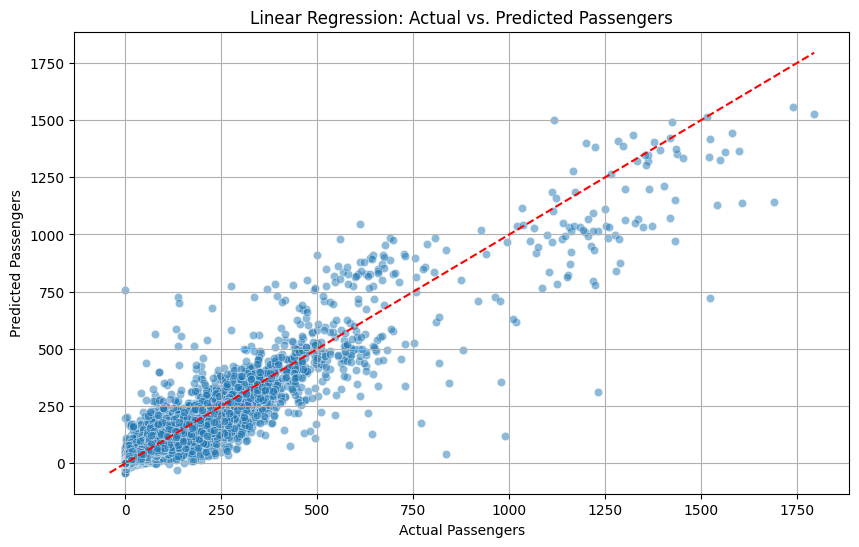

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
plot_data_lr = pd.DataFrame({'Actual': y_lr_test, 'Prediction': y_lr_test_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Prediction', data=plot_data_lr, alpha=0.5)
plt.title('Linear Regression: Actual vs. Predicted Passengers')
plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.grid(True)

# Add a line representing perfect predictions (y=x)
min_val = min(plot_data_lr['Actual'].min(), plot_data_lr['Prediction'].min())
max_val = max(plot_data_lr['Actual'].max(), plot_data_lr['Prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()


## Random Forest Regressor

Evaluate the model based on MAE, RMSE and R2 values.

In [43]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_rf_test_pred = rf.predict(x_rf_test)

# Calculate metrics for the test set
mae_test_rf = mean_absolute_error(y_rf_test, y_rf_test_pred)
rmse_test_rf = root_mean_squared_error(y_rf_test, y_rf_test_pred)
r2_test_rf = r2_score(y_rf_test, y_rf_test_pred)

print("\nRandom Forest Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_test_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_rf}")
print(f"R-squared (R2): {r2_test_rf}")


Random Forest Model Performance on Test Data:
Mean Absolute Error (MAE): 5.4708138445003405
Root Mean Squared Error (RMSE): 14.458717049367882
R-squared (R2): 0.9504763115244428


Plot the actual vs predicted passengers graph.

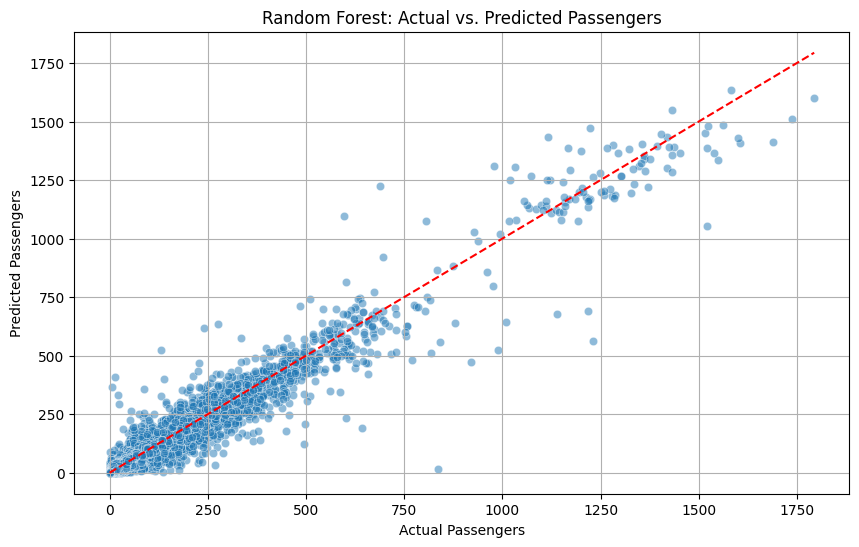

In [44]:
# Create a DataFrame for plotting
plot_data_rf = pd.DataFrame({'Actual': y_rf_test, 'Prediction': y_rf_test_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Prediction', data=plot_data_rf, alpha=0.5)
plt.title('Random Forest: Actual vs. Predicted Passengers')
plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.grid(True)

# Add a line representing perfect predictions (y=x)
min_val = min(plot_data_rf['Actual'].min(), plot_data_rf['Prediction'].min())
max_val = max(plot_data_rf['Actual'].max(), plot_data_rf['Prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## LightGBM Regressor

Evaluate the model based on MAE, RMSE and R2 values.

In [45]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_lgb_test_pred = lgb_r.predict(x_lgb_test)

# Calculate metrics for the test set
mae_test_lgb = mean_absolute_error(y_lgb_test, y_lgb_test_pred)
rmse_test_lgb = root_mean_squared_error(y_lgb_test, y_lgb_test_pred)
r2_test_lgb = r2_score(y_lgb_test, y_lgb_test_pred)

print("\nLightGBM Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_test_lgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_lgb}")
print(f"R-squared (R2): {r2_test_lgb}")


LightGBM Model Performance on Test Data:
Mean Absolute Error (MAE): 5.753633689442883
Root Mean Squared Error (RMSE): 14.334575417020757
R-squared (R2): 0.9513230752510368


Plot the actual vs predicted passengers graph.

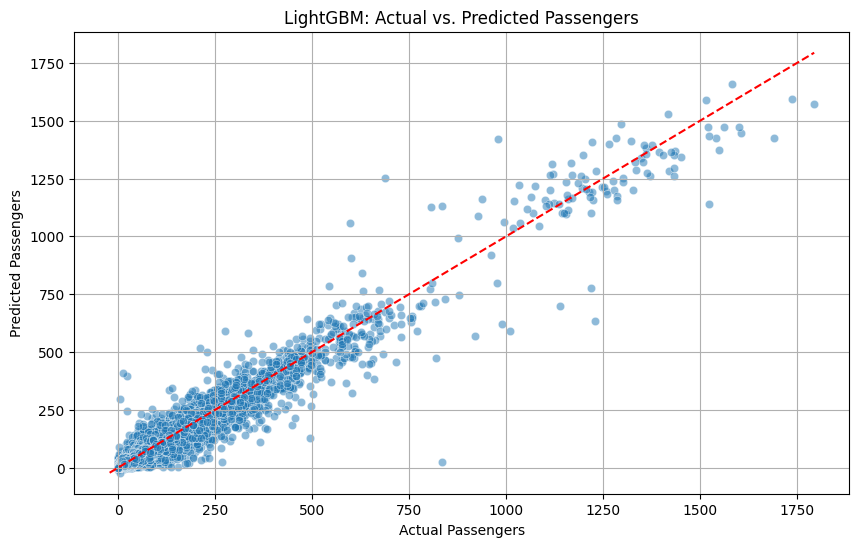

In [46]:
# Create a DataFrame for plotting
plot_data_lgb = pd.DataFrame({'Actual': y_lgb_test, 'Prediction': y_lgb_test_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Prediction', data=plot_data_lgb, alpha=0.5)
plt.title('LightGBM: Actual vs. Predicted Passengers')
plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.grid(True)

# Add a line representing perfect predictions (y=x)
min_val = min(plot_data_lgb['Actual'].min(), plot_data_lgb['Prediction'].min())
max_val = max(plot_data_lgb['Actual'].max(), plot_data_lgb['Prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## SARIMAX

Evaluate the model based on MAE, RMSE and R2 values. Plot predictions vs actuals for KL Sentral station passengers.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



SARIMAX Model Performance on Test Data (KL Sentral):
Mean Absolute Error (MAE): 67.9914247795898
Root Mean Squared Error (RMSE): 124.51835987483041
R-squared (R2): 0.8104106300478543


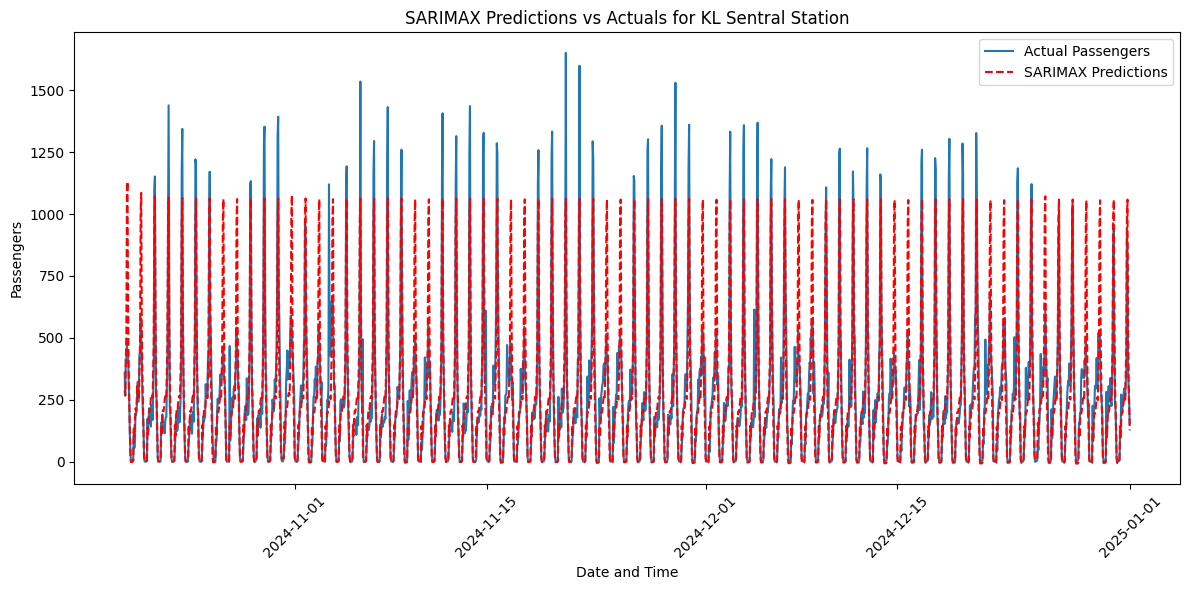

In [47]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Make predictions
y_sarimax_test_pred = sarimax_results.predict(start=len(y_sarimax_train),
                                              end=len(y_sarimax) - 1,
                                              exog=exog_sarimax_test)

# Evaluate the model
mae_test_sarimax = mean_absolute_error(y_sarimax_test, y_sarimax_test_pred)
rmse_test_sarimax = root_mean_squared_error(y_sarimax_test, y_sarimax_test_pred)
r2_test_sarimax = r2_score(y_sarimax_test, y_sarimax_test_pred)

print("\nSARIMAX Model Performance on Test Data (KL Sentral):")
print(f"Mean Absolute Error (MAE): {mae_test_sarimax}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_sarimax}")
print(f"R-squared (R2): {r2_test_sarimax}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_sarimax_test.index, y_sarimax_test, label='Actual Passengers')
plt.plot(y_sarimax_test.index, y_sarimax_test_pred, color='red', linestyle='--', label='SARIMAX Predictions')
plt.title('SARIMAX Predictions vs Actuals for KL Sentral Station')
plt.xlabel('Date and Time')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prophet

Evaluate the model based on MAE, RMSE and R2 values. Plot predictions vs actuals for KL Sentral station passengers.


Prophet Model Performance on Test Data (KL Sentral):
Mean Absolute Error (MAE): 52.276172385586385
Root Mean Squared Error (RMSE): 85.55203317937881
R-squared (R2): 0.9105031251450171


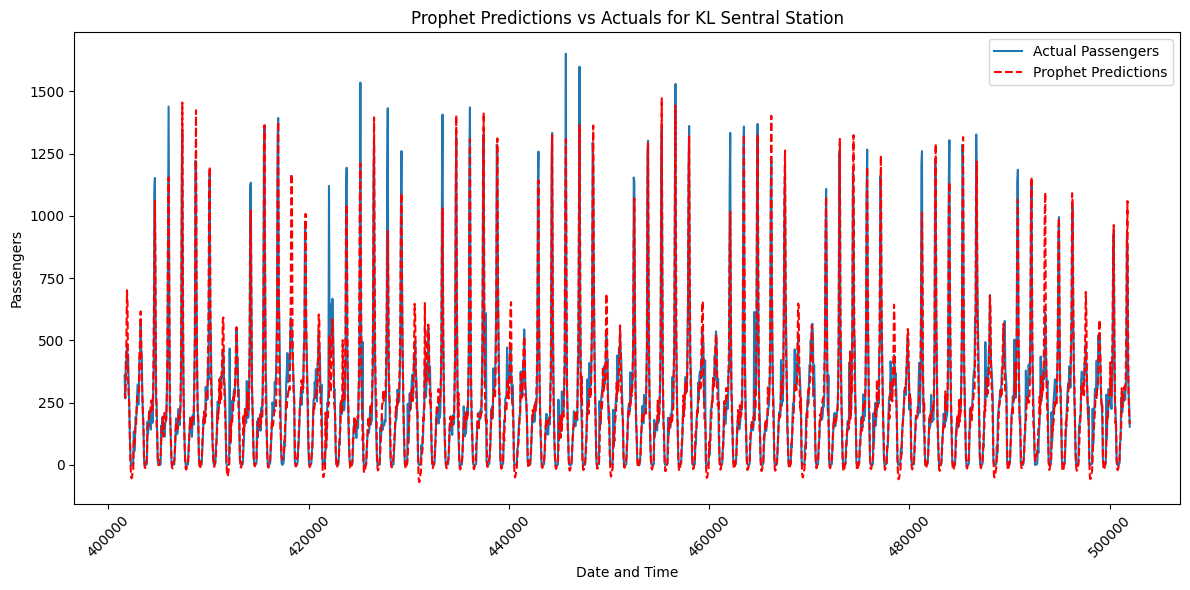

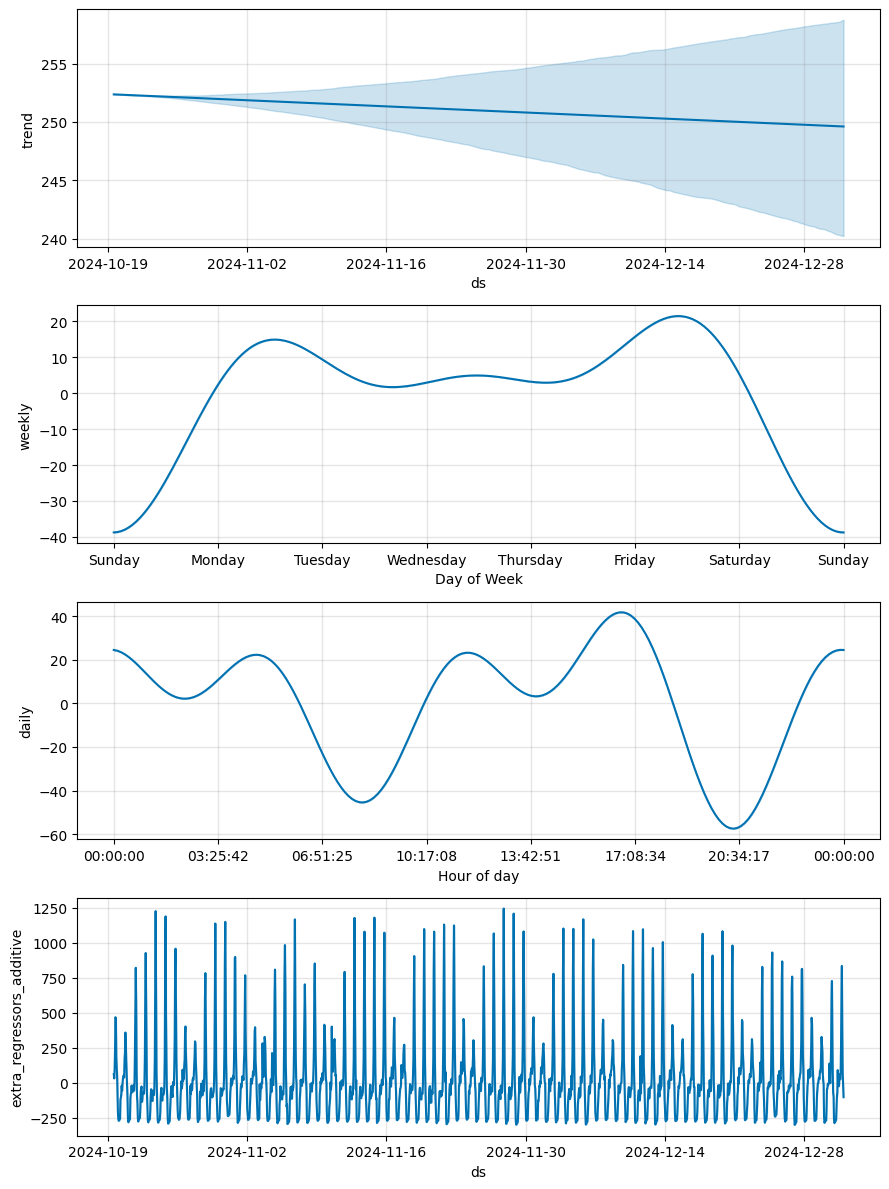

In [48]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create future dataframe for prediction (including regressors for the test period)
future = prophet_test.drop(columns=['y']).rename(columns={'ds': 'ds'}) # Keep only 'ds' and regressors from test set

# Make predictions
forecast = prophet_model.predict(future)

# Extract predictions
y_prophet_test_pred = forecast['yhat']
y_prophet_test_actual = prophet_test['y']

# Ensure indices align for evaluation
y_prophet_test_pred.index = y_prophet_test_actual.index

# Evaluate the model
mae_test_prophet = mean_absolute_error(y_prophet_test_actual, y_prophet_test_pred)
rmse_test_prophet = root_mean_squared_error(y_prophet_test_actual, y_prophet_test_pred)
r2_test_prophet = r2_score(y_prophet_test_actual, y_prophet_test_pred)

print("\nProphet Model Performance on Test Data (KL Sentral):")
print(f"Mean Absolute Error (MAE): {mae_test_prophet}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_prophet}")
print(f"R-squared (R2): {r2_test_prophet}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_prophet_test_actual.index, y_prophet_test_actual, label='Actual Passengers')
plt.plot(y_prophet_test_pred.index, y_prophet_test_pred, color='red', linestyle='--', label='Prophet Predictions')
plt.title('Prophet Predictions vs Actuals for KL Sentral Station')
plt.xlabel('Date and Time')
plt.ylabel('Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components (optional)
fig2 = prophet_model.plot_components(forecast)
plt.show()

## LSTM

Evaluate the model based on MAE, RMSE and R2 values.

In [49]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Make predictions
y_lstm_test_pred = model.predict(x_lstm_test)

# Flatten predictions to match the original y shape
y_lstm_test_pred = y_lstm_test_pred.flatten()

# Calculate metrics for the test set
mae_test_lstm = mean_absolute_error(y_lstm_test, y_lstm_test_pred)
rmse_test_lstm = root_mean_squared_error(y_lstm_test, y_lstm_test_pred)
r2_test_lstm = r2_score(y_lstm_test, y_lstm_test_pred)

print("\nLSTM Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_test_lstm}")
print(f"Root Mean Squared Error (RMSE): {rmse_test_lstm}")
print(f"R-squared (R2): {r2_test_lstm}")

3138/3138 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step

LSTM Model Performance on Test Data:
Mean Absolute Error (MAE): 5.706888675689697
Root Mean Squared Error (RMSE): 14.250555038452148
R-squared (R2): 0.9518920183181763


Plot the actual vs predicted passengers graph.

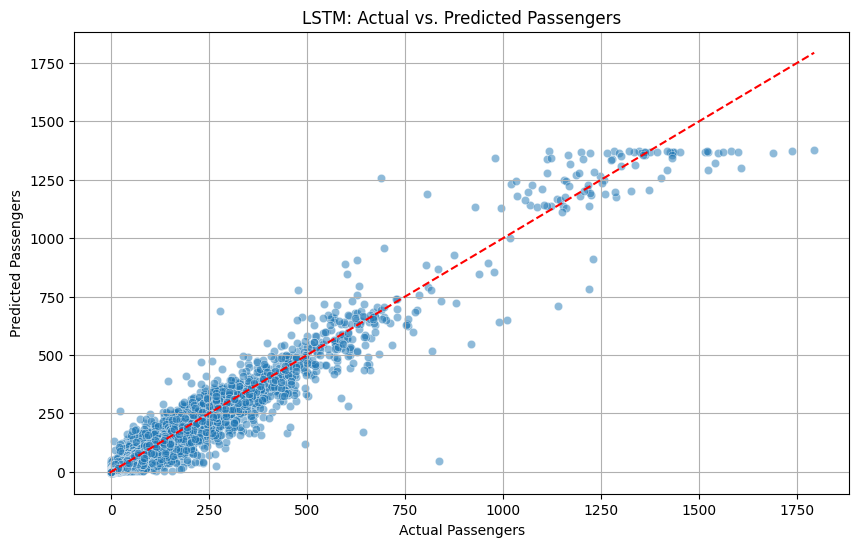

In [50]:
# Create a DataFrame for plotting
plot_data_lstm = pd.DataFrame({'Actual': y_lstm_test, 'Prediction': y_lstm_test_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Prediction', data=plot_data_lstm, alpha=0.5)
plt.title('LSTM: Actual vs. Predicted Passengers')
plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.grid(True)

# Add a line representing perfect predictions (y=x)
min_val = min(plot_data_lstm['Actual'].min(), plot_data_lstm['Prediction'].min())
max_val = max(plot_data_lstm['Actual'].max(), plot_data_lstm['Prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()